<h1>Line of sight (los) integration of a sphere, torus, and other profiles</h1>

In [231]:
import numpy as np                           
import matplotlib.pyplot as plt              
from astropy.coordinates import SkyCoord
import pandas as pd
from astroquery.jplhorizons import Horizons

from IPython.display import Image
from IPython.display import Video
from tqdm.autonotebook import tqdm
from matplotlib import animation

plt.style.use('thomas')

In [232]:
plt.style.use('thomas')   

<h1>Recap: Line-of-sight integration</h1>

<h1>$F(l,b;\vec{\phi}) = \frac{1}{4\pi} \int_0^{+\infty}\,ds \rho(x(s),y(s),z(s);\vec{\phi})$</h1>

<h1>Sphere example</h1>

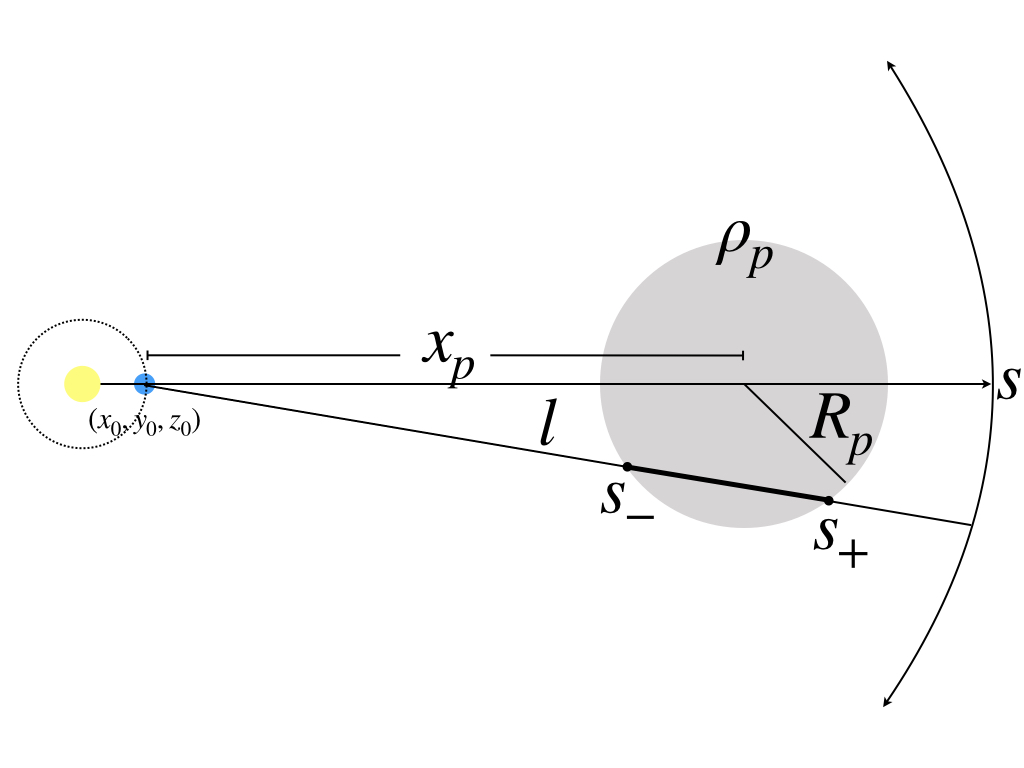

In [233]:
with open('los_sphere.jpg','rb') as f:
    display(Image(data=f.read(), format='png',width=800),)

<h1>Homogeneously filled sphere at $(x_p,y_p,z_p)$ with radius $R_p$ and "density" $\rho_p$:<br>
    $\Rightarrow \rho(x,y,z) = \rho_p~\forall (x-x_p)^2 + (y-y_p)^2 + (z-z_p)^2 \leq R_p^2$ and $0~else$</h1>

<h1>Integral from $0$ to $+\infty$ is thus converted to finding the intersection of each line of sight with the sphere.<br><br>
    The line of sight is defined by starting a vector from Earth to infinity:<br>
    $x(s) = x_0 + s\cos(\phi)\cos(\theta)$<br>
    $y(s) = y_0 + s\sin(\phi)\cos(\theta)$<br>
    $z(s) = z_0 + s\sin(\theta)$</h1>

<h1>This is analytically(!) solvabale and gives:<br>
    $s_{\pm} = -p \pm \sqrt{p^2 + R_p^2 - (\Delta r)^2}$ with<br>
    $p(\phi,\theta) = \Delta x \cos(\phi)\cos(\theta) + \Delta y \sin(\phi)\cos(\theta) + \Delta z \sin(\theta)$<br>
    $\Delta x = x_0-x_p$, $\Delta y = y_0-y_p$, $\Delta z = z_0-z_p$, and $\Delta r = \sqrt{(\Delta x)^2 + (\Delta y)^2 + (\Delta z)^2 }$</h1>

<h1>This the solution of the integral is:<br>
    $F(\phi,\theta) = \frac{\rho_p}{4\pi}2\sqrt{p^2 + R_p^2 - (\Delta r)^2}$<br>
    with a little exception...</h1>

<h1>In python:</h1>

In [234]:
def los_sphere(phi,theta,x0,y0,z0,rhop,xp,yp,zp,Rp):
    Delta_x = x0-xp
    Delta_y = y0-yp
    Delta_z = z0-zp
    Delta_r = np.sqrt(Delta_x**2 + Delta_y**2 + Delta_z**2)
    p = Delta_x*np.cos(theta)*np.cos(phi) + Delta_y*np.cos(theta)*np.sin(phi) + Delta_z*np.sin(theta)
    k0 = np.sqrt(p**2 + Rp**2 - Delta_r**2)
    
    sp = -p+k0
    sm = -p-k0
    
    val = rhop/(4*np.pi)*2*k0
    
    # other exceptions: if inside the sphere (not included here)
    
    #print(idx)
    idx = np.where((sp < 0) | (sm < 0))
    
    val[idx[0],idx[1]] = 0
    val[np.isnan(val)] = 0
    
    return val

<h1>Defining the sky:</h1>

In [235]:
# pixel edges
# polar angle  (poles at +-pi)
theta_arrg = np.linspace(-np.pi/2,np.pi/2,181)
# azimuthal angle
phi_arrg = np.linspace(-np.pi,np.pi,361)

# pixel centres
theta_arr = (theta_arrg[0:-1]+theta_arrg[1:])/2
phi_arr = (phi_arrg[0:-1]+phi_arrg[1:])/2

# make a 'meshgrid', i.e. row and column vector repitions so that
# a m-vector of x coordinates with a n-vector of y coordinates
# become two m x n repeated rows of x and columns of y
PHI_ARRg,THETA_ARRg = np.meshgrid(phi_arrg,theta_arrg)
PHI_ARR,THETA_ARR = np.meshgrid(phi_arr,theta_arr)

# pixel size in azimuthal direction
binsize = np.diff(theta_arr)[0]

# jacobian (integral measure on a sphere, exact for this pixel definition, should be 4pi)
dOmega = (np.sin(THETA_ARR+binsize/2)-np.sin(THETA_ARR-binsize/2))*binsize

In [236]:
# cross check
np.sum(dOmega),4*np.pi

(12.566370614359531, 12.566370614359172)

<h3>Making a few examples:</h3>

In [237]:
# all lengths units are the same. can be cm, AU, kpc
sphere1 = los_sphere(PHI_ARR,THETA_ARR,
                     1,0,0, # Earth / observer position
                     1,     # rho / includes all the physics
                     10,0,0,# sphere position 
                     2)     # radius


/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


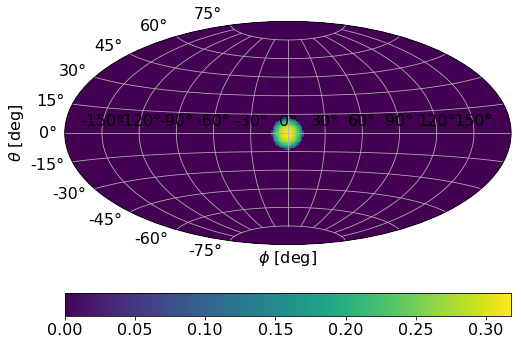

In [238]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,sphere1)
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel(r'$\theta$ [deg]')
plt.grid()
plt.colorbar(orientation='horizontal')

In [239]:
sphere2 = los_sphere(PHI_ARR,THETA_ARR,1,0,0,1,3,2,20,10)

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


Text(0, 0.5, '$\\theta$ [deg]')

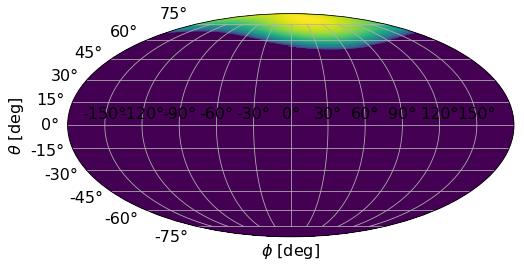

In [240]:
plt.subplot(projection='mollweide')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,sphere2)
plt.grid()
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel(r'$\theta$ [deg]')

<h3>Other example: Exaggerating the epicycles of Mars:</h3>

In [241]:
# orbital parameters of Earth and Mars, assuming everything is on a circle
# in the ecliptic

P_earth = 365.256
tt = np.arange(0,P_earth*4.2707*4,7)

P_earth = 365.256
omega_earth = 2*np.pi/P_earth*tt
r_earth = 1.
x_earth = r_earth*np.cos(omega_earth) 
y_earth = r_earth*np.sin(omega_earth)
z_earth = np.zeros(len(tt))

P_mars = 779.94
omega_mars = 2*np.pi/P_mars*tt
r_mars = 1.524
x_mars = r_mars*np.cos(omega_mars)
y_mars = r_mars*np.sin(omega_mars)
z_mars = np.zeros(len(tt))

In [242]:
# transform cartesian ecliptic (solar system) coordinates to cartesian galactic coordinates

def trafo_EC2GAL_car(x_ec,y_ec,z_ec):
    deg2rad = np.pi/180
    theta = 60.188*deg2rad
    phi = 96.377*deg2rad
    
    x_gal =  x_ec*np.cos(theta)*np.cos(phi) - y_ec*np.sin(phi) + z_ec*np.sin(theta)*np.cos(phi)
    y_gal =  x_ec*np.cos(theta)*np.sin(phi) + y_ec*np.cos(phi) + z_ec*np.sin(theta)*np.sin(phi)
    z_gal = -x_ec*np.sin(theta)                                + z_ec*np.cos(theta)
    
    return x_gal,y_gal,z_gal

In [243]:
# do the transformation of the coordinates

x_earth_gal, y_earth_gal, z_earth_gal = trafo_EC2GAL_car(x_earth,y_earth,z_earth)
x_mars_gal, y_mars_gal, z_mars_gal = trafo_EC2GAL_car(x_mars,y_mars,z_mars)

In [14]:
# calculate oversized Mars positions as a los-integrated sphere over the time scale

mars_motion = np.zeros((len(tt),PHI_ARR.shape[0],PHI_ARR.shape[1]))

# loop over all positions and do los integration
# might take a bit
for p in tqdm(range(len(tt))):
    mars_motion[p,:,:] = los_sphere(PHI_ARR,THETA_ARR,
                         x_earth_gal[p],y_earth_gal[p],z_earth_gal[p],
                         1,
                         x_mars_gal[p],y_mars_gal[p],z_mars_gal[p],0.1)

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


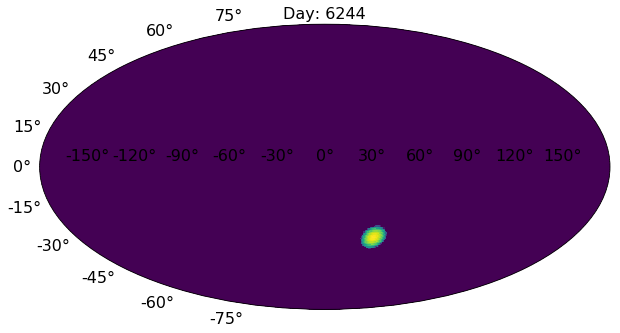

In [15]:
"""# we created 892 separate images of where the planet appears as seen from Earth
# no we put that together in an animation

fig, ax = plt.subplots(figsize=(10.24,7.68),subplot_kw={'projection':'aitoff'},nrows=1,ncols=1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

ims = []
for i in tqdm(range(len(tt))):
    ttl = plt.text(0.5, 1.01, r'Day: '+str('%i' % ((i+1)*7)), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    ims.append([ax.pcolormesh(PHI_ARRg,THETA_ARRg,mars_motion[i,:,:]),ttl])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=0)

ani.save('epicycles.mp4')"""

In [16]:
# creating the file might take a while but then we can watch it here:

Video('epicycles.mp4')

In [17]:
# hope you see the epicycles

<h1>LOS of a homogeneously filled torus with large radius $R_T$ and small (tube) radius $R_t$:<br>
    Torus: $\left(\sqrt{(x-x_T)^2 + (y-y_T)^2} - R_T^2\right)^2 + (z-z_T)^2 - R_t^2 = 0$</h1>

In [244]:
def los_torus_solution(phi,theta,x0,y0,z0,rhoT,xT,yT,zT,RT,Rt):
    Delta_x = x0-xT
    Delta_y = y0-yT
    Delta_z = z0-zT
    Delta_r = np.sqrt(Delta_x**2 + Delta_y**2 + Delta_z**2)
    p = Delta_x*np.cos(theta)*np.cos(phi) + Delta_y*np.cos(theta)*np.sin(phi) + Delta_z*np.sin(theta)
    q = np.cos(theta)*(Delta_x*np.cos(phi)+Delta_y*np.sin(phi))
    xi = np.sqrt(Delta_r**2 + RT**2 - Rt**2)
    nu = (4*RT**2*Delta_x**2 + 4*RT**2*Delta_y**2)**(0.25)
    A = 1.
    B = 4*p
    C = 4*p**2 + 2*xi**2 - 4*RT**2*np.cos(theta)**2
    D = 4*p*xi**2 - 8*RT**2*q
    E = xi**4 - nu**4
    
    # can't use vectorisation of np.roots() is used
    # are there analytic solutions to arbitrary quartic equations?
    # use np.vectorize() instead later
    x1,x2,x3,x4 = np.roots([A,B,C,D,E])

    delta = np.arctan2(y0,x0)

    # solution only valid if observer sits inside torus but on in tube
    return np.max([(x1-x2).real,(x3-x4).real])

In [245]:
# because the np.roots() function doesnt take 'multiple polynomials' at the same time
# (i.e. it can only handle one coordinate pair phi/theta at once)
# we vectorise the function, so that it can

vlos_torus = np.vectorize(los_torus_solution)

<h3>Example: MBA torus as seen from Earth at some time of the year:</h3>

In [246]:
# calculation takes some 5-6 seconds for me
# note that if we could write down the analytic solution for that quartic equation,
# we would save a lot of computation time

torus1 = vlos_torus(PHI_ARR,THETA_ARR,
                   1/np.sqrt(2),1/np.sqrt(2),0, # Earth
                   1,     # rho
                   0,0,0, # position of torus (not all values valid with definition above)
                   2.8,   # large radius
                   0.5)   # small radius

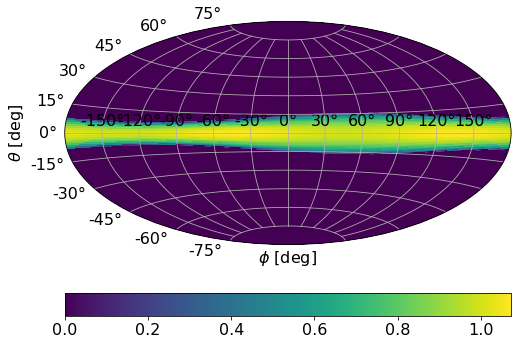

In [247]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,torus1)
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel(r'$\theta$ [deg]')
plt.grid()
plt.colorbar(orientation='horizontal')

<h3>Now let's transform that to Galactic Coordinates:<br>
    Because we didn't want to calculate the new shape of the transformed cartesian coordinates, we use the transformation of the spherical coordinates instead and the interpolate the old image on the new (transformed) grid:</h3>

In [248]:
from numpy import cos, sin, tan, arccos, arcsin, arctan, arctan2

In [249]:
# same transformation as above just solved for the angles instead of x,y,z

def trafo_ec2gal(phi,theta,deg=False):
    deg2rad = np.pi/180
    alpha = 60.188*deg2rad
    beta = 96.377*deg2rad
    
    lat = arcsin(-sin(alpha)*cos(phi)*cos(theta) + cos(alpha)*sin(theta))
    
    lon = arctan2(cos(alpha)*sin(beta)*cos(phi)*cos(theta) + sin(alpha)*sin(beta)*sin(theta) + cos(beta)*sin(phi)*cos(theta),
                  cos(alpha)*cos(beta)*cos(phi)*cos(theta) + sin(alpha)*cos(beta)*sin(theta) - sin(beta)*sin(phi)*cos(theta))
    
    if deg == True:
        return lon/deg2rad,lat/deg2rad
    else:
        return lon,lat

In [251]:
# inverse transformation

def trafo_gal2ec(lon,lat,deg=False):
    deg2rad = np.pi/180
    alpha = 60.188*deg2rad
    beta = 96.377*deg2rad
    
    theta = arcsin(sin(alpha)*cos(beta)*cos(lon)*cos(lat) + sin(alpha)*sin(beta)*sin(lon)*cos(lat) + cos(alpha)*sin(lat))
    
    phi = arctan2(-sin(beta)*cos(lon)*cos(lat) + cos(beta)*sin(lon)*cos(lat),
                  cos(alpha)*cos(beta)*cos(lon)*cos(lat) + cos(alpha)*sin(beta)*sin(lon)*cos(lat) - sin(alpha)*sin(lat))
    
    if deg == True:
        return phi/deg2rad,theta/deg2rad
    else:
        return phi,theta

In [252]:
from scipy.interpolate import griddata # for the interpolation

In [253]:
# I now included a keyword 'galactic' that returns the torus in Galactic
# coordiantes instead of Ecliptic if set to True (default)

def los_torus(phi,theta,x0,y0,z0,rhoT,xT,yT,zT,RT,Rt,galactic=True):
    torus = vlos_torus(phi,theta,# in rad
                       x0,y0,z0, # Earth / Observer
                       rhoT,     # rho
                       xT,yT,zT, # position of torus (not all values valid with definition above)
                       RT,       # large radius
                       Rt)       # small radius
    
    if galactic == True:
        
        # trafo to gal. coordinates
        lon,lat = trafo_ec2gal(phi,theta,deg=False)
        
        # interpolate ecliptic torus to new irregular grid
        torus_gal = griddata((lon.ravel(), lat.ravel()),    # new coordinates are not regular any more
                             torus.ravel(),                 # the image stays the same, just gets re-arranged
                             (phi.ravel(), theta.ravel()),  # the representation we want to be the same (regular grid)
                             method='nearest')              # nearest neighbour interpolation avoids 'edge effects'
        
        torus_gal = torus_gal.reshape(phi.shape) # rebuild the image to be a regular 2D array
        
        return torus_gal
    
    else:
        
        return torus

In [254]:
# same as above, just now as seen in Galactic coordinates

torus2 = los_torus(PHI_ARR,THETA_ARR,
                   1/np.sqrt(2),1/np.sqrt(2),0, # Earth
                   1,     # rho
                   0,0,0, # position of torus (not all values valid with definition above)
                   2.8,   # large radius
                   0.5,   # small radius
                   galactic=True)

Text(0, 0.5, 'Gal. Lat. [deg]')

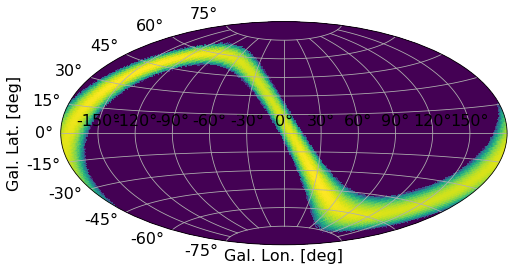

In [255]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,torus2)
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

<h3>I believe, except for details in orbit, inclination and eccentricity, this is our zero-order model</h3>

In [256]:
# cross check for consistency by using the integrated map before and after the transformation

# before
print(np.sum(torus1*dOmega))

# after
print(np.sum(torus2*dOmega))

2.027017244306763
2.0275641163154


In [257]:
# rather accurate

In [258]:
# to subtract

torus01 = los_torus(PHI_ARR,THETA_ARR,
                   0,0,0, # Earth
                   1,     # rho
                   0,0,0, # position of torus (not all values valid with definition above)
                   2.8,   # large radius
                   0.5,   # small radius
                   galactic=False)

torus02 = los_torus(PHI_ARR,THETA_ARR,
                   0,0,0, # Earth
                   1,     # rho
                   0,0,0, # position of torus (not all values valid with definition above)
                   2.8,   # large radius
                   0.45,   # small radius
                   galactic=False)

Text(0, 0.5, 'Gal. Lat. [deg]')

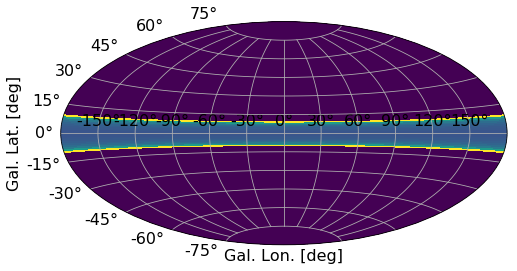

In [259]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,torus01-torus02)
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

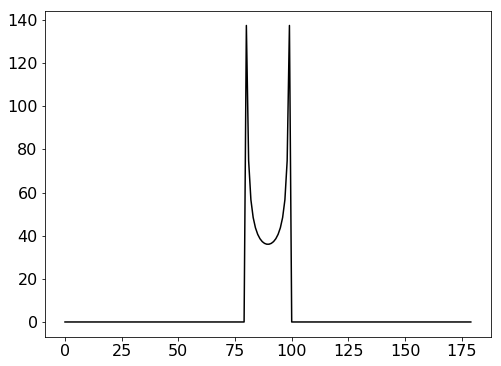

In [260]:
plt.plot(np.sum(torus01-torus02,axis=1))

<h3>Other possibility to define the torus:<br><br>
    $\rho(x,y,z) = \rho_0 \exp\left(-\frac{1}{2}\left( \frac{R_{xy} - R_T}{\sigma_T} \right)^2\right) \exp\left(-\frac{1}{2}\left( \frac{z - z_t}{\sigma_t} \right)^2\right)$<br>
    with $R_{xy}^2 = x^2 + y^2$.<br><br>
    The definitions are similar to the ones above just that the density is distributed with a Gaussian profile in the radial dimension and a Gaussian in the veritcal dimension. This makes the object "smooth", but also possibly very extended. If $\sigma_t = \sigma_T$, the torus is circular; if $\sigma_t > \sigma_T$, the vertical extent is larger. The latter is a first approximation of trojans, but the true shape actually looks different.</h3>

<h3>Plitting an example and then programming the full function and line of sight integration for this object:</h3>

In [261]:
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
z = np.linspace(-10,10,100)

X, Y, Z = np.meshgrid(x,y,z)

In [262]:
Rxy = np.sqrt(X**2 + Y**2)

In [263]:
X.shape

(100, 100, 100)

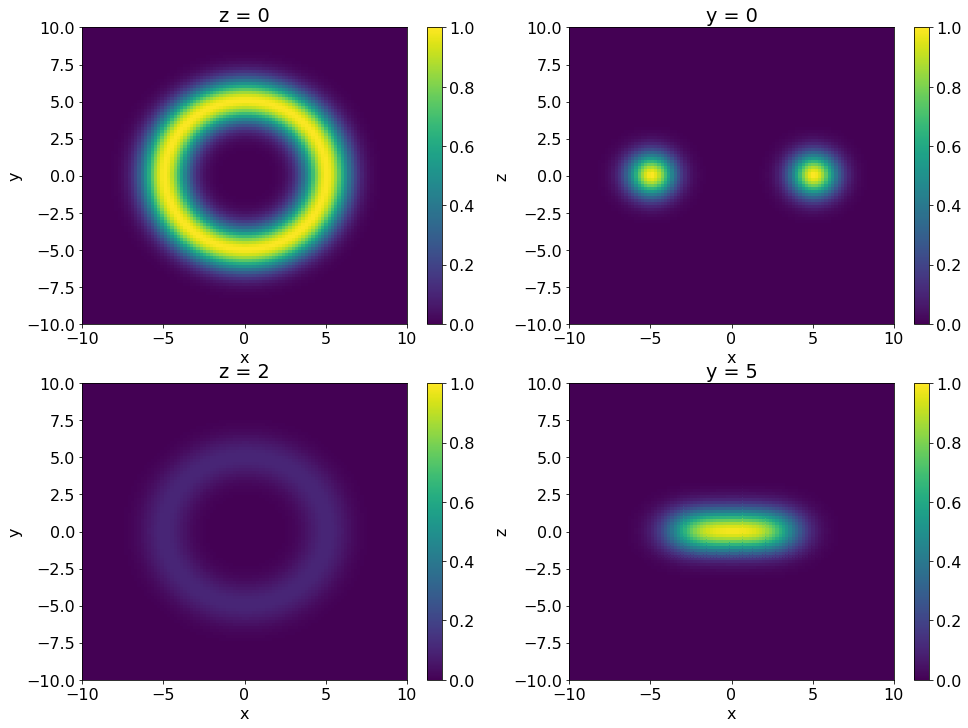

In [279]:
plt.figure(figsize=(16,12))

zdx = 50
plt.subplot(221)
plt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],np.exp(-0.5*(Rxy[:,:,zdx]-5)**2.0/1**2)*np.exp(-0.5*(Z[:,:,zdx]-0)**2.0/1**2),vmin=0,vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('z = 0')
plt.colorbar()

ydx = 50
plt.subplot(222)
plt.pcolormesh(X[ydx,:,:],Z[ydx,:,:],np.exp(-0.5*(Rxy[ydx,:,:]-5)**2.0/1**2)*np.exp(-0.5*(Z[ydx,:,:]-0)**2.0/1**2),vmin=0,vmax=1)
plt.xlabel('x')
plt.ylabel('z')
plt.title('y = 0')
plt.colorbar()

zdx = 60
plt.subplot(223)
plt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],np.exp(-0.5*(Rxy[:,:,zdx]-5)**2.0/1**2)*np.exp(-0.5*(Z[:,:,zdx]-0)**2.0/1**2),vmin=0,vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('z = 2')
plt.colorbar()

ydx = 75
plt.subplot(224)
plt.pcolormesh(X[ydx,:,:],Z[ydx,:,:],np.exp(-0.5*(Rxy[ydx,:,:]-5)**2.0/1**2)*np.exp(-0.5*(Z[ydx,:,:]-0)**2.0/1**2),vmin=0,vmax=1)
plt.xlabel('x')
plt.ylabel('z')
plt.title('y = 5')
plt.colorbar()

<h3>Here I was just playing around with suppressing the full torus everywhere except some positions (might be useful later for the trojans)</h3>

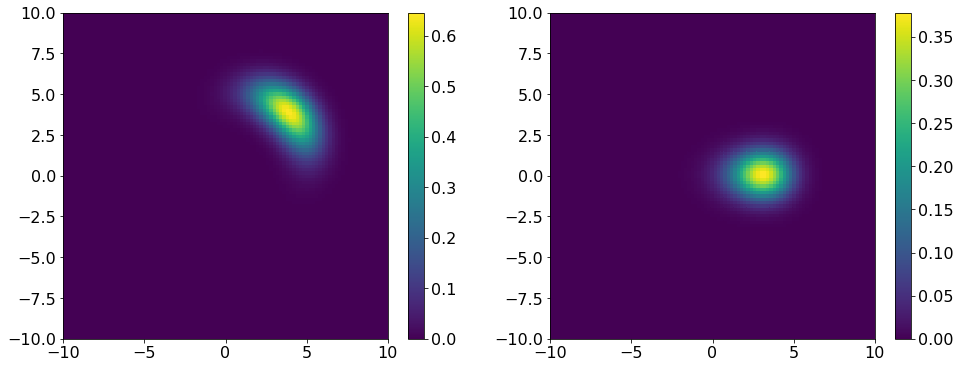

In [280]:
zdx = 50

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],np.exp(-0.5*(Rxy[:,:,zdx]-5)**2.0/1**2)*np.exp(-0.5*(Z[:,:,zdx]-0)**2.0/1**2)*np.exp(-0.5*((X[:,:,zdx]-5)**2 + (Y[:,:,zdx]-5)**2)/2**2))
plt.colorbar()

ydx = 75
plt.subplot(122)
plt.pcolormesh(X[ydx,:,:],Z[ydx,:,:],np.exp(-0.5*(Rxy[ydx,:,:]-5)**2.0/1**2)*np.exp(-0.5*(Z[ydx,:,:]-0)**2.0/1**2)*np.exp(-0.5*((X[ydx,:,:]-5)**2 + (Y[ydx,:,:]-5)**2)/2**2))
plt.colorbar()

<h3>Now the los integration:</h3>

In [281]:
from numba import jit, njit, prange
from numpy import cos, sin, fabs, cosh, exp, pi, sqrt

In [283]:
from math import erf

@jit(nopython=True)
def Gaussian_Torus(s,b,l):
    
    # coordinates of the observer in AU from the Sun
    x0 = 0.
    y0 = -1.
    z0 = 0.
    
    # los vector
    x = x0 + s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 + s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 + s*sin(deg2rad*b)
    
    # model parameters for MBA torus
    RT = 2.8
    Rt = 0.0
    sigmaT = 1/6
    
    # width for trojans
    sigma_troj = 1.
    
    Rxy = sqrt(x**2 + y**2)
    
    # complete torus: (here sigma_t = sigma_T)
    val = exp(-1/(2*sigmaT**2)*((Rxy - RT)**2 + (z - Rt)**2))
    
    # trojans
    #T1 = sqrt(((x-RT*cos(0))**2 + (y-RT*sin(0))**2)/sigma_troj**2)
    #val1 = exp(-1/(2*sigmaT**2)*((Rxy - RT)**2 + (z - Rt)**2)) * np.exp(-0.5*T1**2)#*(1+erf(6*T1/sqrt(2)))
    
    #T2 = sqrt(((x-RT*cos(2*pi/3))**2 + (y-RT*sin(2*pi/3))**2)/sigma_troj**2)
    #val2 = exp(-1/(2*sigmaT**2)*((Rxy - RT)**2 + (z - Rt)**2)) * np.exp(-0.5*T2**2)#*(1+erf(-6*T2/sqrt(2)))

    #val = val1 + val2
    
    return val

In [284]:
"""zdx = 50
RT = 5

psi = 4/8*pi

T1 = sqrt(((X[:,:,zdx]-RT*cos(psi))**2 + (Y[:,:,zdx]-RT*sin(psi))**2)/2**2)

plt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],
               np.exp(-0.5*(Rxy[:,:,zdx]-RT)**2.0/1**2)*np.exp(-0.5*(Z[:,:,zdx]-0)**2.0/1**2)*\
               np.exp(-0.5*T1**2)*\
               (1+erf(4*sin(psi)*(X[:,:,zdx]-RT*cos(psi))/2/sqrt(2)))*\
               (1+erf(4*cos(psi)*(Y[:,:,zdx]-RT*sin(psi))/2/sqrt(2))))
"""

'zdx = 50\nRT = 5\n\npsi = 4/8*pi\n\nT1 = sqrt(((X[:,:,zdx]-RT*cos(psi))**2 + (Y[:,:,zdx]-RT*sin(psi))**2)/2**2)\n\nplt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],\n               np.exp(-0.5*(Rxy[:,:,zdx]-RT)**2.0/1**2)*np.exp(-0.5*(Z[:,:,zdx]-0)**2.0/1**2)*               np.exp(-0.5*T1**2)*               (1+erf(4*sin(psi)*(X[:,:,zdx]-RT*cos(psi))/2/sqrt(2)))*               (1+erf(4*cos(psi)*(Y[:,:,zdx]-RT*sin(psi))/2/sqrt(2))))\n'

<h3>For the following, see complete example below (here I just define the image space and los vector (s):</h3>

In [286]:
# definition of image space

# minmax range (similar to above but now also including s)
lmin,lmax = -180,180
bmin,bmax = -90,90
deg2rad = pi/180

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 1.0
n_l = int((lmax-lmin)/binsize)
n_b = int((bmax-bmin)/binsize)

# range for line of sight integration only important near galactic centre
# will be very close to zero outside 6 kpc radius from centre
# the value 6 kpc is empirical; the outskirts around 20 deg require also the very wide values
srange = 6.
# sun position
x0 = 0.
y0 = 0.
z0 = 0.
smin,smax = 0,srange

# use resolutin of 5 pc = 2ds / n_los_steps ~ 240
# also here driven empirical
n_los_steps = 240

# define lon, lat, and los arrays, with and without boundaries
# similar to above with phi and theta arrays, but now with s
s = np.linspace(smin,smax,n_los_steps)
ds = np.diff(s)[0] # los element
bg = np.linspace(bmin,bmax,n_b+1)
lg = np.linspace(lmin,lmax,n_l+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

In [287]:
# meshgrid for 3D space: image-los
# same as for anglesbut now with a third dimension of length included

grid_s, grid_b, grid_l = np.meshgrid(s,b,l,indexing="ij")

In [288]:
# vectorised los 3D array
# takes a few seconds

torus_map = cos(deg2rad*grid_b)*np.vectorize(Gaussian_Torus)(grid_s, grid_b, grid_l)

In [289]:
# final step is to sum over s:

# calculation of model by integrating over ds (all ds are the same so sum is appropriate)
torus_G = np.sum(torus_map*ds,axis=0)

In [290]:
from matplotlib import colors

Text(0, 0.5, 'Gal. Lat. [deg]')

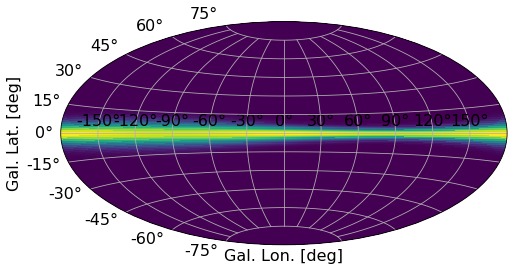

In [291]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,torus_G,norm=colors.PowerNorm(1.0))
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

<h3>Image transformations back and forth:</h3>

In [292]:
def trafo_image_EC2GAL(phi,theta,image):

    # trafo to gal. coordinates
    lon,lat = trafo_ec2gal(phi,theta,deg=False)

    # interpolate ecliptic torus to new irregular grid
    image_gal = griddata((lon.ravel(), lat.ravel()),    # new coordinates are not regular any more
                         image.ravel(),                 # the image stays the same, just gets re-arranged
                         (phi.ravel(), theta.ravel()),  # the representation we want to be the same (regular grid)
                         method='nearest')              # nearest neighbour interpolation avoids 'edge effects'

    image_gal = image_gal.reshape(phi.shape) # rebuild the image to be a regular 2D array
    
    return image_gal

In [293]:
def trafo_image_GAL2EC(lon,lat,image):

    # trafo to gal. coordinates
    phi,theta = trafo_gal2ec(lon,lat,deg=False)

    # interpolate ecliptic torus to new irregular grid
    image_ec = griddata((phi.ravel(), theta.ravel()),    # new coordinates are not regular any more
                         image.ravel(),                 # the image stays the same, just gets re-arranged
                         (lon.ravel(), lat.ravel()),  # the representation we want to be the same (regular grid)
                         method='nearest')              # nearest neighbour interpolation avoids 'edge effects'

    image_ec = image_ec.reshape(lon.shape) # rebuild the image to be a regular 2D array
    
    return image_ec

In [296]:
# ec to gal
torus_G_gal = trafo_image_EC2GAL(PHI_ARR,THETA_ARR,torus_G)

Text(0, 0.5, 'Gal. Lat. [deg]')

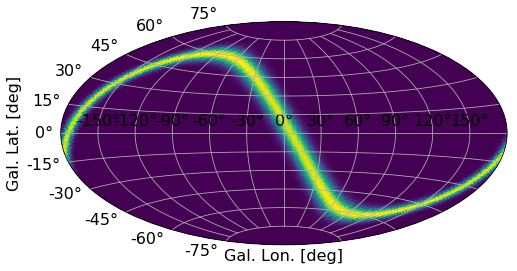

In [297]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,torus_G_gal,norm=colors.PowerNorm(1.0))
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

In [298]:
# back from gal to ec
torus_G_ec = trafo_image_GAL2EC(PHI_ARR,THETA_ARR,torus_G_gal)

Text(0, 0.5, 'Gal. Lat. [deg]')

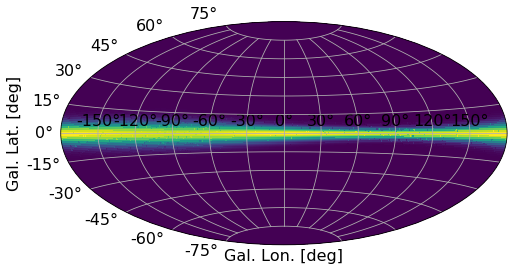

In [299]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,torus_G_ec,norm=colors.PowerNorm(1.0))
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

In [300]:
# comparison of integrated flux
np.sum(torus_G*domega),np.sum(torus_G_ec*domega)

(0.4482656554523389, 0.4479803905373461)

<h3>Checking how this this then looks like in the sky compared to the diffuse 511 keV map:</h3>

In [301]:
def Gaussian2D(x,y,A,x0,y0,sx,sy):
    
    return A*np.exp(-0.5*((x-x0)**2/sx**2 + (y-y0)**2/sy**2))

In [303]:
gc_blob = Gaussian2D(PHI_ARR,THETA_ARR,1,1*deg2rad,0,8/2.355*deg2rad,6/2.355*deg2rad)
disk_blob = Gaussian2D(PHI_ARR,THETA_ARR,1,0,0,60*deg2rad,10*deg2rad)

gc_blob /= np.sum(gc_blob*domega)/1e-3
disk_blob /= np.sum(disk_blob*domega)/1.7e-3

# the values come from different papers, e.g. Siegert et al 2016

In [304]:
torus_G_gal = trafo_image_EC2GAL(PHI_ARR,THETA_ARR,torus_G)
torus_G_gal /= np.sum(torus_G_gal*domega)/4e-4

torus_gal = trafo_image_EC2GAL(PHI_ARR,THETA_ARR,torus1)
torus_gal /= np.sum(torus_gal*domega)/4e-4

# here I normalise the flux of the full torus (both cases) to the values from the Moskalenko papers

<h3>Expectation for full sky</h3>

Text(0, 0.5, 'Gal. Lat. [deg]')

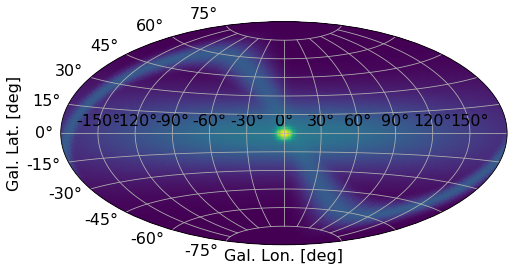

In [308]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,gc_blob+disk_blob+torus_G_gal,norm=colors.PowerNorm(0.25))
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

<h3>And zoomed in to Galactic center</h3>

(-15, 15)

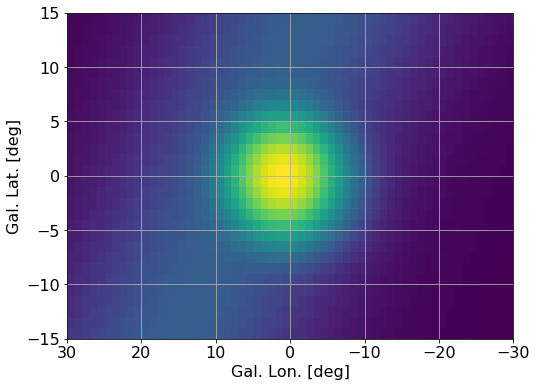

In [309]:
plt.pcolormesh(PHI_ARRg/deg2rad,THETA_ARRg/deg2rad,gc_blob*0.8+disk_blob*0.0+torus_G_gal,norm=colors.PowerNorm(0.25))
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')
plt.xlim(30,-30)
plt.ylim(-15,15)

In [310]:
np.sum(torus_G_gal*domega)

0.00040000000000000013

In [311]:
np.sum(gc_blob*domega)

0.0009999999999999998

<h3>Then I was playing with the Lagrange potential, but somehow couldn't get what I wanted...</h3>

In [312]:
m1 = 10.
m2 = 1.
m_tot = m1 + m2

mu = m1/m_tot

x = np.linspace(-4,4,100)
y = np.linspace(-4,4,100)
z = np.linspace(-4,4,100)

X, Y, Z = np.meshgrid(x,y,z)

u = - (1-mu)/(np.sqrt((X + mu)**2 + Y**2)) - mu/(np.sqrt((X - (1-mu))**2 + Y**2)) - 0.5*(X**2 + Y**2)

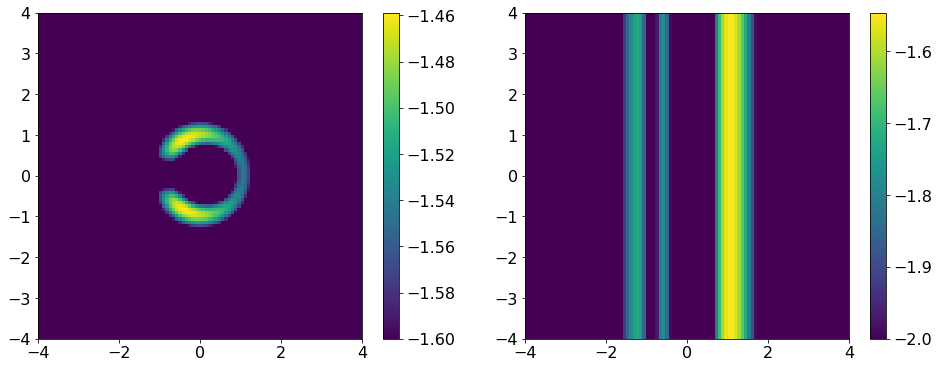

In [313]:
zdx = 50

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],u[:,:,zdx],norm=colors.PowerNorm(1),vmin=-1.6)
plt.colorbar()

ydx = 50
plt.subplot(122)
plt.pcolormesh(X[ydx,:,:],Z[ydx,:,:],u[ydx,:,:],vmin=-2)
plt.colorbar()

In [218]:
vec_r1 = np.array([0,0,0.])
vec_r2 = np.array([2,0,0.])

In [219]:
u_arr = np.zeros(X.shape)

vec_omega = 1*np.array([x[0]*0,y[0]*0,1.])


for i in tqdm(range(100)):
    for j in range(100):
        for k in range(100):
            
            vec_r = np.array([x[i],y[j],z[k]])
            
            
            u_arr[i,j,k] = -m1/np.linalg.norm(vec_r-vec_r1) -m2/np.linalg.norm(vec_r-vec_r2) - 0.5*np.dot(np.cross(vec_omega,vec_r),np.cross(vec_omega,vec_r))

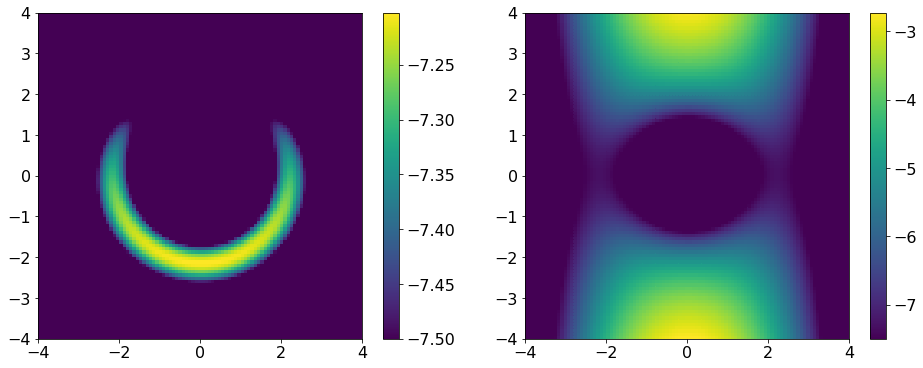

In [230]:
zdx = 50

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(X[:,:,zdx],Y[:,:,zdx],u_arr[:,:,zdx],norm=colors.PowerNorm(1),vmin=-7.5)
plt.colorbar()

ydx = 50
plt.subplot(122)
plt.pcolormesh(X[ydx,:,:],Z[ydx,:,:],u_arr[ydx,:,:],vmin=-7.5)
plt.colorbar()

<h3>Checking different asteroids ...</h3>

In [314]:
from astropy.coordinates import SkyCoord     # coordinate transformations
import pandas as pd                          # I/O of data in table format
from astroquery.jplhorizons import Horizons  # python interface to HORIZONS

In [315]:
obj = Horizons(id='2004 KV18',id_type='smallbody',
               location='500',               # Earth centre
               epochs={'start':'1990-10-03', # dictionary that includes the times we want
                       'stop':'1997-11-03',  # NB: exactly the same as I used for my example
                       'step':'720h'})

In [316]:
tmp_eph = obj.ephemerides()

In [317]:
print(tmp_eph)

 targetname    datetime_str   datetime_jd  H  ... alpha_true  PABLon   PABLat
    ---            ---             d      mag ...    deg       deg      deg  
----------- ----------------- ----------- --- ... ---------- -------- -------
(2004 KV18) 1990-Oct-03 00:00   2448167.5 8.9 ...     0.3782 190.0849 -9.5909
(2004 KV18) 1990-Nov-02 00:00   2448197.5 8.9 ...     1.1268 190.8995 -9.5727
(2004 KV18) 1990-Dec-02 00:00   2448227.5 8.9 ...     1.9244 191.5837 -9.5958
(2004 KV18) 1991-Jan-01 00:00   2448257.5 8.9 ...     2.2689 192.0233 -9.6463
(2004 KV18) 1991-Jan-31 00:00   2448287.5 8.9 ...     2.0256  192.155  -9.701
(2004 KV18) 1991-Mar-02 00:00   2448317.5 8.9 ...     1.2448 191.9991 -9.7325
(2004 KV18) 1991-Apr-01 00:00   2448347.5 8.9 ...     0.3981 191.6674 -9.7181
(2004 KV18) 1991-May-01 00:00   2448377.5 8.9 ...     1.1941 191.3304 -9.6496
(2004 KV18) 1991-May-31 00:00   2448407.5 8.9 ...      2.014  191.153 -9.5366
(2004 KV18) 1991-Jun-30 00:00   2448437.5 8.9 ...     2.3412 191

In [320]:
tmp_eph_df = tmp_eph.to_pandas()

In [321]:
gl_tmp = tmp_eph_df['GlxLon'].values
gl_tmp[gl_tmp>180] -= 360
gb_tmp = tmp_eph_df['GlxLat'].values
jd_tmp = tmp_eph_df['datetime_jd'].values

In [324]:
"""
# second object
gl_tmp2 = tmp_eph_df['GlxLon'].values
gl_tmp2[gl_tmp2>180] -= 360
gb_tmp2 = tmp_eph_df['GlxLat'].values
jd_tmp2 = tmp_eph_df['datetime_jd'].values"""

"\n# second object\ngl_tmp2 = tmp_eph_df['GlxLon'].values\ngl_tmp2[gl_tmp2>180] -= 360\ngb_tmp2 = tmp_eph_df['GlxLat'].values\njd_tmp2 = tmp_eph_df['datetime_jd'].values"

Text(0, 0.5, 'Gal. Lat. [deg]')

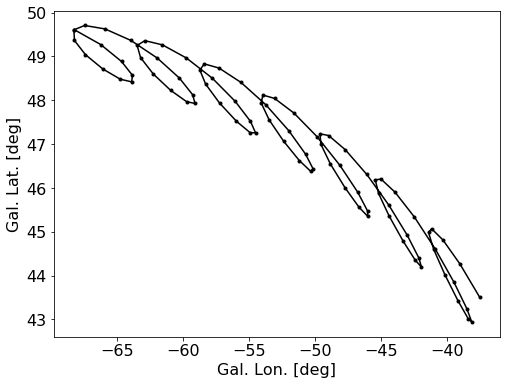

In [329]:
plt.plot(gl_tmp,gb_tmp,'.-')
#plt.plot(gl_tmp2,gb_tmp2,'.')
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')

In [333]:
# in 7 years, asteroid only moved ~20 deg (!)

In [334]:
"""from tsiegert_tools import angular_distance"""

'from tsiegert_tools import angular_distance'

In [327]:
"""plt.plot(jd_tmp,angular_distance(gl_tmp,gb_tmp,gl_tmp2,gb_tmp2))"""

'plt.plot(jd_tmp,angular_distance(gl_tmp,gb_tmp,gl_tmp2,gb_tmp2))'

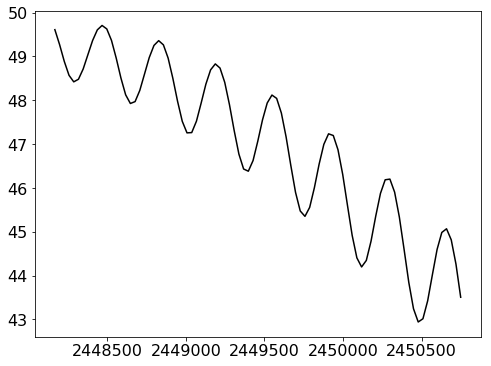

In [328]:
plt.plot(jd_tmp,gb_tmp)

<h1>Movie of Earth around the Sun, seeing the MBA torus:</h1>

In [68]:
# 52 points in one year (simpler v ersion than above with Earth and Mars)
N = 52
omega = np.linspace(0,2*np.pi*(1-1/N),N)

xsol = np.cos(omega) 
ysol = np.sin(omega)

In [69]:
mba_motion = np.zeros((len(xsol),PHI_ARR.shape[0],PHI_ARR.shape[1]),dtype=complex)

# loop over all positions and do los integration
# might take a few minutes
for p in tqdm(range(len(xsol))):
    mba_motion[p,:,:] = los_torus(PHI_ARR,THETA_ARR,xsol[p],ysol[p],0,1,0,0,0,2.8,0.5)

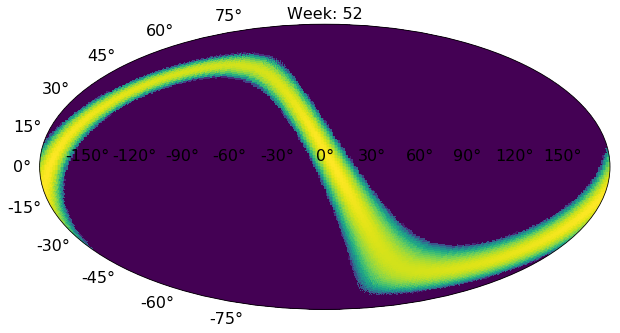

In [71]:
# same as above, just that the video is much shorter

fig, ax = plt.subplots(figsize=(10.24,7.68),subplot_kw={'projection':'aitoff'},nrows=1,ncols=1)

ims = []
for i in tqdm(range(len(xsol))):
    ttl = plt.text(0.5, 1.01, r'Week: '+str('%i' % (i+1)), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    ims.append([ax.pcolormesh(PHI_ARRg,THETA_ARRg,mba_motion[i,:,:].real),ttl])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=0)

ani.save('MBA_blob_galactic.mp4')

In [72]:
Video('MBA_blob_galactic.mp4')

<h1>What to do next:<br>
    <ol>
        <li>Include more objects into the scheme: different MBA potions, trojans of major planets, Kuiper belt, Oort cloud, ...: i.e. construct similar functions to los_torus() for different objects; how would one model the trojans? exception for the los integration of the sphere for the Oort cloud as a shell surrounding the solar system, etc.</li>
        <li>Include real time and orbit parameters to the model: Earth's orbit is eccentric (not circular) and inclined; specific coordinates should correspond to actual times (e.g. 23th of July 2005, or IJD something): i.e. construct a function that takes the correct Earth position (maybe from HORIZONs? - and more realistic MBA shape?) at time IJD and calculate (and plot) the image</li>
    </ol>

<h1>How to do LOS integration when the density profile is not homogeneous:</h1>

In [404]:
from numba import jit, njit, prange
from numpy import cos, sin, fabs, cosh, exp, pi, sqrt

In [76]:
def sech(x):
    return 1/np.cosh(x)

<h1>Consider the density profile:<br><br>
    $\rho_{BB}(x,y,z)/\rho_{0,BB} = \left \{
  \begin{aligned}
    &sech^2\left(R_s\right), && \text{for}\ R \leq R_{end} \\
    &sech^2\left(R_s\right) \times \exp\left(-(R_s-R_{end})^2/h_{end}^2\right), && \text{for}\ R > R_{end} \\
  \end{aligned} \right. $<br>with<br>
  $    R_s = \left\{ \left[ \left(\frac{|x|}{a_x}\right)^{C_{\bot}} + \left(\frac{|y|}{a_y}\right)^{C_{\bot}} \right]^{\frac{C_{||}}{C_{\bot}}} + \left(\frac{|z|}{a_z}\right)^{C_{||}} \right\}^{\frac{1}{C_{||}}}$
  <br>
  This describes a bar-like structure, an ellipsoid but which goes sharply to nearly zero at some boundary, but formally extends to infinity.<br>
  The integration can be done in the following way:</h1>

In [77]:
# here I use numba, a python package which magically makes parallelisable operations faster
# the idea here is to just program the density function as is, plug in the line of sight vector
# as a function of s, l, and b, and choose the steps of s small enough to perform a sum over s

@jit(nopython=True)
def F98gal(s,b,l):
    # the model is from the paper Freudenreich (1998) which is why it's called F98
    
    # coordinates of the observer in kpc (from the galactic centre)
    x0 = 8.5
    y0 = 0
    z0 = 0.01646
    
    # los vector
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    
    # model parameters from that paper
    phi = 13.97*deg2rad
    theta = 0
    barX = 1.696
    barY = 0.6426
    barZ = 0.4425
    barPerp = 1.574
    barPara = 3.501
    barREnd = 3.128
    barHEnd = 0.461
    
    # rotating the bar
    xp = cos(phi)*cos(theta)*x + sin(phi)*y - cos(phi)*sin(theta)*z
    yp = -sin(phi)*cos(theta)*x + cos(phi)*y + sin(phi)*sin(theta)*z
    zp = sin(theta)*x + cos(theta)*z
    
    # calculate the function from above
    rPerp = ((fabs(xp)/barX)**barPerp + (fabs(yp)/barY)**barPerp)**(1/barPerp)
    rs = (rPerp**barPara  + (fabs(zp)/barZ)**barPara)**(1/barPara)

    # two cases from above
    if rs <= barREnd:
        return 1/cosh(rs)**2
    else:
        return exp(-(rs-barREnd)**2/barHEnd**2)/cosh(rs)**2

In [81]:
# definition of image space

# minmax range (similar to above but now also including s)
lmin,lmax = -180,180
bmin,bmax = -90,90
deg2rad = pi/180

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 1.0
n_l = int((lmax-lmin)/binsize)
n_b = int((bmax-bmin)/binsize)

# range for line of sight integration only important near galactic centre
# will be very close to zero outside 6 kpc radius from centre
# the value 6 kpc is empirical; the outskirts around 20 deg require also the very wide values
srange = 6.
# sun position
x0 = 8.5
y0 = 0
z0 = 0.01646
smin,smax = x0-srange,x0+srange
# that is equivalent to setting everything outside a sphere of 6 kpc radius around the Galactic centre to 0

# use resolutin of 5 pc = 2ds / n_los_steps ~ 240
# also here driven empirical
n_los_steps = 240

# define lon, lat, and los arrays, with and without boundaries
# similar to above with phi and theta arrays, but now with s
s = np.linspace(smin,smax,n_los_steps)
ds = np.diff(s)[0] # los element
bg = np.linspace(bmin,bmax,n_b+1)
lg = np.linspace(lmin,lmax,n_l+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

In [83]:
# meshgrid for 3D space: image-los
# same as for anglesbut now with a third dimension of length included

grid_s, grid_b, grid_l = np.meshgrid(s,b,l,indexing="ij")

In [84]:
# vectorised los 3D array
# takes a few seconds

bb_map = cos(deg2rad*grid_b)*np.vectorize(F98gal)(grid_s, grid_b, grid_l)

In [86]:
# bb_map is not an 'image' of 180x360 pixels at each of the distance (s) bins

bb_map.shape

(240, 180, 360)

<h3>It's important to understand what's happening, so we visualise this again in an animation.<br>
    The back and forth loop might remind you of an MRI slicing: it is <em>exactly</em> that, just that our slices are spherical around the observer.</h3>

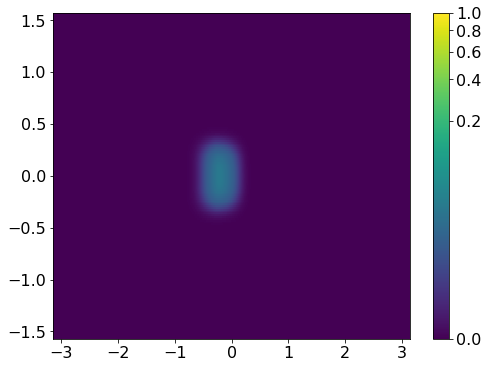

In [145]:
plt.pcolormesh(PHI_ARRg,THETA_ARRg,bb_map[40,:,:],vmin=0,vmax=1,norm=colors.PowerNorm(0.25))
plt.colorbar()

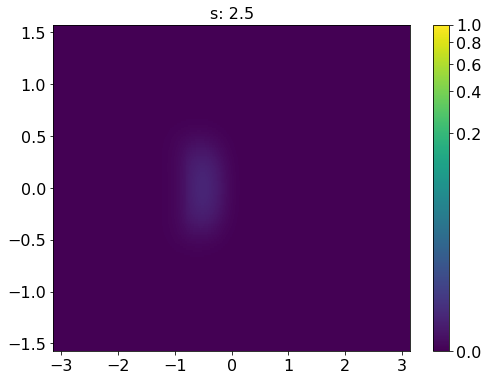

In [158]:
# same as above, just with another scaling and back and forth loop
from matplotlib import colors

fig, ax = plt.subplots(figsize=(8,6),nrows=1,ncols=1)

ims = []
for i in tqdm(range(len(s))):
    ttl = plt.text(0.5, 1.01, r's: '+str('%.1f' % (s[i])), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    img = ax.pcolormesh(PHI_ARRg,THETA_ARRg,bb_map[i,:,:],vmin=0,vmax=1,norm=colors.PowerNorm(0.25))
    ims.append([img,ttl])
for i in tqdm(range(len(s))):
    ttl = plt.text(0.5, 1.01, r's: '+str('%.1f' % (s[len(s)-i-1])), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    img = ax.pcolormesh(PHI_ARRg,THETA_ARRg,bb_map[len(s)-i-1,:,:],vmin=0,vmax=1,norm=colors.PowerNorm(0.25))
    ims.append([img,ttl])

fig.colorbar(img)

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=0)

ani.save('bb_map_slices.mp4')

In [159]:
Video('bb_map_slices.mp4')

In [161]:
# final step is to sum over s:

# calculation of model by integrating over ds (all ds are the same so sum is appropriate)
bb = np.sum(bb_map*ds,axis=0)

In [162]:
# bb is now the final map that sums over all the maps from above in slices

bb.shape

(180, 360)

Text(0, 0.5, 'Gal. Lat. [deg]')

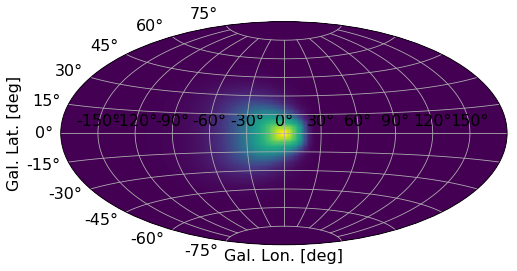

In [166]:
plt.subplot(projection='aitoff')
plt.pcolormesh(PHI_ARRg,THETA_ARRg,bb,norm=colors.PowerNorm(0.125))
plt.grid()
plt.xlabel(r'Gal. Lon. [deg]')
plt.ylabel(r'Gal. Lat. [deg]')

<h1>LOS integration continued: converting fluxes and luminosities ...<br>
    later...</h1>

<h1>Integrating a map (integration of a function on a sphere):<br>

$F = \int\,d\Omega F(\phi,\theta) = \int_{-\pi}^{+\pi}\,d\phi\int_{-\pi/2}^{+\pi/2}\,d\theta \cos(\theta) F(\phi,\theta)$</h1>

In [73]:
# from first torus:
np.sum(torus1*dOmega)

2.027017244306763

<h1>This means for the parameters $(x_0,y_0,z_0) = (1,0,0)\,\mathrm{AU}$, $\rho = 1\,\mathrm{s^{-1}\,AU^{-3}}$ (units invented, but should be per unit time and unit volume), $(x_T,y_T,z_T) = (0,0,0)\,\mathrm{AU}$ (centred on the position of the Sun, $R_T = 2.8\,\mathrm{AU}$, and $R_t = 0.5\,\mathrm{AU}$, the total flux of the entire sky received at Earth is $2.027\,\mathrm{photons\,s^{-1}\,AU^{-2}}$.<br>
    Per AU-squared is not necessarily a useful unit for us, so we'd convert that into $\mathrm{photons\,s^{-1}\,cm^{-2}}$.</h1>

<h1>What we are interested in the end is the luminosity ("power", energy per time, or photons per time) that comes from this torus, so we have to integrate over the distance sphere as well (remember for a point source it was $L = \frac{F}{4 \pi d^2}$ with $d$ as the distance):<br>
    $L = \int\,d\Omega\int_0^{+\infty}\,ds\,s^2\,\rho(x(s,\phi,\theta),y(s,\phi,\theta),z(s,\phi,\theta))$</h1>

<h1>You see that this is even for the homogeneous sphere case not analytically solvable any more (pretty sure).<br>
    The integral over $s$ however is, so we can do it in two steps:<br>
    $L = \frac{\rho_p}{3}\int\,d\Omega\,(s_+^3 - s_-^3)$</h1>

<h3>(For the torus, this would be very similar, maybe you can make a function for yourself.)</h3>

<h1>Sphere example continued:</h1>

In [98]:
sphere1 = los_sphere(PHI_ARR,THETA_ARR,
                     1,0,0, # Earth
                     1,     # rho
                     10,0,0,# sphere
                     1)     # radius

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [99]:
def lumi_sphere(phi,theta,x0,y0,z0,rhop,xp,yp,zp,Rp,dOmega):
    Delta_x = x0-xp
    Delta_y = y0-yp
    Delta_z = z0-zp
    Delta_r = np.sqrt(Delta_x**2 + Delta_y**2 + Delta_z**2)
    p = Delta_x*np.cos(theta)*np.cos(phi) + Delta_y*np.cos(theta)*np.sin(phi) + Delta_z*np.sin(theta)
    k0 = np.sqrt(p**2 + Rp**2 - Delta_r**2)
    
    sp = -p+k0
    sm = -p-k0
    
    val = rhop/3*(sp**3 - sm**3)

    # exceptions
    idx = np.where((sp < 0) | (sm < 0))
    
    val[idx[0],idx[1]] = 0
    val[np.isnan(val)] = 0
    
    lumi = np.sum(val*dOmega)
    
    return lumi

<h3>Flux of sphere1 (integrating over the sky, as seen "from Earth"):</h3>

In [100]:
np.sum(sphere1*dOmega)

0.004091873452014718

<h3>Intrinsic(!) luminosity of the sphere:</h3>

In [101]:
lumi_sphere(PHI_ARR,THETA_ARR,
                     1,0,0, # Earth
                     1,     # rho
                     10,0,0,# sphere
                     1,     # radius 
                     dOmega)

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


4.155074001619979

<h1>In summary this means, with the given parameters, a measured flux of $0.00409$ would correspond to an intrinsic brightness of $4.155$.<br>
    (I ignored the units here, but they must correspond to each other of course.)</h3>